In [1]:
import numpy as np
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.steinbrinker.BPDN import BPDN
import pickle as pkl
from datetime import datetime

In [2]:
GEN_DATA_SIZE = 10000
INP_SMPL_FREQ = 250
GEN_SIG_SECS  = 10
VALID_INP_SIGS = 362

In [3]:
inp_sigs = np.load('data/steinbrinker/testing_data_mvg_avg.npy')[:, :VALID_INP_SIGS]

In [4]:
bw = wfdb.rdrecord('data/mit-bih/bw')

In [5]:
bw, _ = processing.resample_sig(bw.p_signal[:, 1], bw.fs, INP_SMPL_FREQ)

In [6]:
gen_sig_len = INP_SMPL_FREQ * GEN_SIG_SECS
max_rand_cut_trg = inp_sigs.shape[0] - gen_sig_len
max_rand_cut_inp = bw.shape[0] - gen_sig_len

## Baseline Wander - without initial BPDN estimate - saving only cut indeces

In [7]:
gen_sigs = np.zeros([3, GEN_DATA_SIZE])
for i in tqdm(range(GEN_DATA_SIZE)):
    # TARGET: choose a random input signal
    gen_sigs[0, i] = np.random.randint(inp_sigs.shape[1])
    # TARGET: cut chosen signal at random location
    gen_sigs[1, i] = np.random.randint(max_rand_cut_trg)
    # INPUT: cut BW noise at random location to be added to the target signal
    gen_sigs[2, i] = np.random.randint(max_rand_cut_inp)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 62466.18it/s]


In [8]:
pkl_outp = {
    'params': {
        'GEN_DATA_SIZE': GEN_DATA_SIZE,
        'INP_SMPL_FREQ': INP_SMPL_FREQ,
        'GEN_SIG_SECS': GEN_SIG_SECS,
        'VALID_INP_SIGS': VALID_INP_SIGS
    },
    'data': gen_sigs
}

In [9]:
dt = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
with open(f'data/generated/BW_master_{GEN_DATA_SIZE}_{dt}.pkl', 'wb') as handle:
    pkl.dump(pkl_outp, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Baseline Wander - without initial BPDN estimate

In [10]:
gen_sigs = np.zeros([2, gen_sig_len, GEN_DATA_SIZE])
for i in tqdm(range(GEN_DATA_SIZE)):
    # TARGET: take a random part of a random imput signal
    rand_sig = np.random.randint(inp_sigs.shape[1])
    rand_cut = np.random.randint(max_rand_cut_trg)
    gen_sigs[1, :, i] = inp_sigs[rand_cut:rand_cut+gen_sig_len, rand_sig]

    # INPUT: add random BW noise to the target signal
    rand_cut = np.random.randint(max_rand_cut_inp)
    gen_sigs[0, :, i] = gen_sigs[1, :, i] + bw[rand_cut:rand_cut+gen_sig_len]

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3517.28it/s]


In [11]:
np.save('data/large/BW_gen_data_master.npy', gen_sigs)

## Baseline Wander - with initial BPDN estimate

In [12]:
dictionary = np.load('data/steinbrinker/dictionary_BW_real_data.npy')

In [13]:
GEN_DATA_SIZE = 10
thresh = 1e-6
lambda_param = 1

In [14]:
gen_sigs = np.zeros([3, gen_sig_len, GEN_DATA_SIZE])
for i in tqdm(range(GEN_DATA_SIZE)):
    # TARGET: take a random part of a random imput signal
    rand_sig = np.random.randint(inp_sigs.shape[1])
    rand_cut = np.random.randint(max_rand_cut_trg)
    gen_sigs[2, :, i] = inp_sigs[rand_cut:rand_cut+gen_sig_len, rand_sig]

    # INPUT: add random BW noise to the target signal
    rand_cut = np.random.randint(max_rand_cut_inp)
    gen_sigs[0, :, i] = gen_sigs[2, :, i] + bw[rand_cut:rand_cut+gen_sig_len]

    # ESTIMATE: perform BPDN on noisy input signal
    alpha = BPDN(gen_sigs[0, :, i], dictionary, lambda_param=lambda_param)[1]
    alpha[np.abs(alpha) < thresh] = 0
    gen_sigs[1, :, i] = gen_sigs[0, :, i] - dictionary@alpha

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.26s/it]


In [15]:
np.save('data/large/BW_gen_data_est_master.npy', gen_sigs)

In [16]:
gen_sigs.shape

(3, 2500, 10)

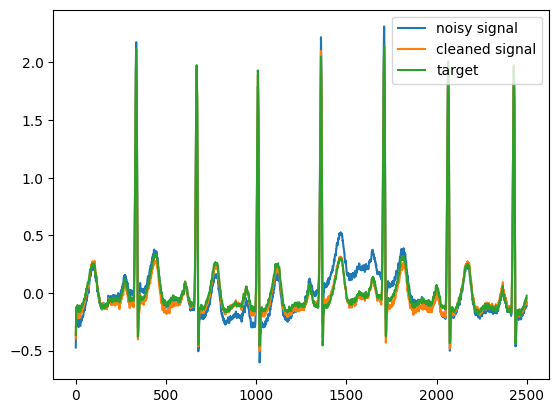

In [17]:
plt.plot(gen_sigs[0:3, :, 9].T)
plt.legend(labels=['noisy signal', 'cleaned signal', 'target'])